In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gzip

In [ ]:

!wget -q http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -O train-images-idx3-ubyte.gz
!wget -q http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -O train-labels-idx1-ubyte.gz
!wget -q http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz -O t10k-images-idx3-ubyte.gz
!wget -q http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz -O t10k-labels-idx1-ubyte.gz

In [ ]:
# load images
with gzip.open('train-images-idx3-ubyte.gz', 'rb') as f:
    x_train = np.frombuffer(f.read(), np.uint8, offset=16)
x_train = x_train.reshape(-1, 784)

with gzip.open('t10k-images-idx3-ubyte.gz', 'rb') as f:
    x_test = np.frombuffer(f.read(), np.uint8, offset=16)
x_test = x_test.reshape(-1, 784)

with gzip.open('train-labels-idx1-ubyte.gz', 'rb') as f:
    y_train = np.frombuffer(f.read(), np.uint8, offset=8)

with gzip.open('t10k-labels-idx1-ubyte.gz', 'rb') as f:
    y_test = np.frombuffer(f.read(), np.uint8, offset=8)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


<Figure size 432x288 with 0 Axes>

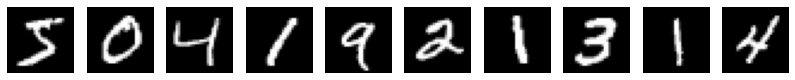

In [ ]:
plt.clf()
fig = plt.figure(figsize=(14, 1.4))
for c in range(10):
    ax = fig.add_subplot(1, 10, c + 1)
    ax.imshow(x_train[c].reshape(28, 28), cmap=plt.get_cmap('gray'))
    ax.set_axis_off()
plt.show()

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    grad = np.zeros(x.shape)
    grad[x > 0] = 1
    return grad

def softmax(x):
    if x.ndim == 2:
        x = x.T
        # x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    # x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

In [ ]:
class MLP:

    def __init__(self, input_size, hidden_size, output_size, act_func='sigmoid', w_std=0.01):
        self.w1 = w_std * np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros(hidden_size)
        self.w2 = w_std * np.random.randn(hidden_size, hidden_size)
        self.b2 = np.zeros(hidden_size)
        self.w3 = w_std * np.random.randn(hidden_size, output_size)
        self.b3 = np.zeros(output_size)

        # 使用する活性化関数の選択
        if act_func == 'sigmoid':
            self.act = sigmoid
            self.act_grad = sigmoid_grad
        elif act_func == 'relu':
            self.act = relu
            self.act_grad = relu_grad
        else:
            print("ERROR")

        self.grads = {}

    def forward(self, x):
        self.h1 = np.dot(x, self.w1) + self.b1
        self.h2 = self.act(self.h1)
        self.h3 = np.dot(self.h2, self.w2) + self.b2
        self.h4 = self.act(self.h3)
        self.h5 = np.dot(self.h4, self.w3) + self.b3
        self.y = softmax(self.h5)
        return self.y

    def backward(self, x, t):
        batch_size = x.shape[0]
        self.grads = {}
        
        t = np.identity(10)[t]
        dy = (self.y - t) / batch_size

        self.grads['w3'] = np.dot(self.h4.T, dy)
        self.grads['b3'] = np.sum(dy, axis=0)

        d_h4 = np.dot(dy, self.w3.T)
        d_h3 = self.act_grad(self.h3) * d_h4
        self.grads['w2'] = np.dot(self.h2.T, d_h3)
        self.grads['b2'] = np.sum(d_h3, axis=0)
        
        d_h2 = np.dot(d_h3, self.w2.T)
        d_h1 = self.act_grad(self.h1) * d_h2
        self.grads['w1'] = np.dot(x.T, d_h1)
        self.grads['b1'] = np.sum(d_h1, axis=0)
        
    def update_parameters(self, lr=0.1):
        self.w1 -= lr * self.grads['w1']
        self.b1 -= lr * self.grads['b1']
        self.w2 -= lr * self.grads['w2']
        self.b2 -= lr * self.grads['b2']  
        self.w3 -= lr * self.grads['w3']
        self.b3 -= lr * self.grads['b3']  

In [ ]:
input_size = x_train.shape[1]
hidden_size = 64
output_size = 10
model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size, act_func='sigmoid')

In [ ]:
# 学習途中の精度を確認するための関数
def multiclass_classification_accuracy(pred, true):
    clf_res = np.argmax(pred, axis=1)
    return np.sum(clf_res == true).astype(np.float32)

# 学習中の誤差を確認するための関数
def cross_entropy(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


num_train_data = x_train.shape[0]
num_test_data = x_test.shape[0]
batch_size = 300 #100→300
epoch_num = 100 #10→100
learning_rate = 0.001 #0.01→0.001?

epoch_list = []
train_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

iteration = 0
for epoch in range(1, epoch_num + 1):
    
    sum_accuracy = 0.0
    sum_loss = 0.0
    
    perm = np.random.permutation(num_train_data)
    for i in range(0, num_train_data, batch_size):
        x_batch = x_train[perm[i:i+batch_size]]
        y_batch = y_train[perm[i:i+batch_size]]
        
        y = model.forward(x_batch)
        sum_accuracy += multiclass_classification_accuracy(y, y_batch)
        sum_loss += cross_entropy(y, y_batch)
        
        model.backward(x_batch, y_batch)
        model.update_parameters(lr=learning_rate)

        iteration += 1
    
    print("epoch: {}, mean loss: {}, mean accuracy: {}".format(epoch,
                                                               sum_loss / num_train_data,
                                                               sum_accuracy / num_train_data))
    
    test_correct_count = 0
    for i in range(num_test_data):
        input = x_test[i:i+1]
        label = y_test[i:i+1]
        y = model.forward(input)
        
        test_correct_count += multiclass_classification_accuracy(y, label)

# 学習途中のlossと精度の保存
    epoch_list.append(epoch)
    train_loss_list.append(sum_loss / num_train_data)
    train_accuracy_list.append(sum_accuracy / num_train_data)
    test_accuracy_list.append(test_correct_count / num_test_data)

epoch: 1, mean loss: 0.0007883327360748737, mean accuracy: 0.9468833333333333
epoch: 2, mean loss: 0.0007668252105023256, mean accuracy: 0.9491666666666667
epoch: 3, mean loss: 0.0007568626278589508, mean accuracy: 0.9500333333333333
epoch: 4, mean loss: 0.0007485660446830809, mean accuracy: 0.9508833333333333
epoch: 5, mean loss: 0.0007413908264882762, mean accuracy: 0.9520166666666666
epoch: 6, mean loss: 0.0007368039217242775, mean accuracy: 0.95245
epoch: 7, mean loss: 0.0007317236034061057, mean accuracy: 0.9527
epoch: 8, mean loss: 0.0007276960107717101, mean accuracy: 0.9533666666666667
epoch: 9, mean loss: 0.0007236614139023105, mean accuracy: 0.9535666666666667
epoch: 10, mean loss: 0.0007199608039222883, mean accuracy: 0.9540833333333333
epoch: 11, mean loss: 0.000716750061434216, mean accuracy: 0.9544666666666667
epoch: 12, mean loss: 0.000713737578008901, mean accuracy: 0.95465
epoch: 13, mean loss: 0.0007111092299999003, mean accuracy: 0.955
epoch: 14, mean loss: 0.0007083

In [ ]:
count = 0
num_test_data = x_test.shape[0]

for i in range(num_test_data):
    x = np.array([x_test[i]], dtype=np.float32)
    t = y_test[i]
    y = model.forward(x)
    
    pred = np.argmax(y.flatten())
    
    if pred == t:
        count += 1
        
print("test accuracy: {}".format(count / num_test_data))

test accuracy: 0.9258


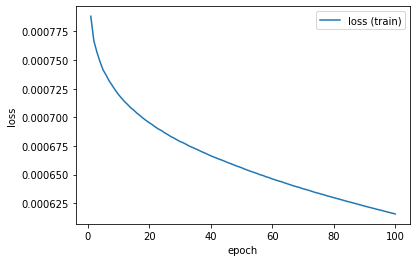

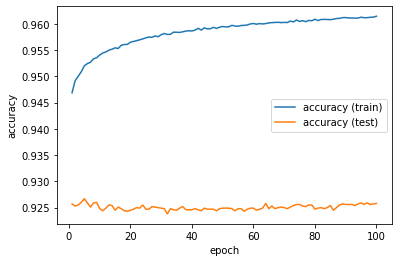

In [ ]:
plt.figure()
plt.plot(epoch_list, train_loss_list, label='loss (train)')
plt.xlabel("epoch")     # x軸ラベル
plt.ylabel("loss")      # y軸ラベル
plt.legend()            # 凡例
plt.show()

plt.figure()
plt.plot(epoch_list, train_accuracy_list, label='accuracy (train)')
plt.plot(epoch_list, test_accuracy_list, label='accuracy (test)')
plt.xlabel("epoch")     # x軸ラベル
plt.ylabel("accuracy")  # y軸ラベル
plt.legend()            # 凡例
plt.show()

#　結果</br>
epochを１００に変更</br>
その結果精度が大幅に上がった。(0.9432)</br>

batchサイズを100→300に変更</br>
その結果精度的には、0.9482→0.9232に落ちたが、学習スピードが上がりました。</br>

larning rateを0.01→0.001に変更
0.9232→0.9258 と多少の精度の改善が見られた。